In [1]:
"""1. Imports"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
"""2: Load Data"""
# Load datasets
bookings = pd.read_csv('Bookings.csv')
sessions = pd.read_csv('Sessions.csv')



In [3]:
""" 3: Data Preparation"""
# Convert 'booking_time' and 'session_starting_time' to datetime format
bookings['booking_time'] = pd.to_datetime(bookings['booking_time'], errors='coerce')
sessions['session_starting_time'] = pd.to_datetime(sessions['session_starting_time'], errors='coerce')


In [4]:
"""4: Find Number of Distinct Bookings, Sessions, and Searches"""
# Find distinct counts
distinct_bookings = bookings['booking_id'].nunique()
distinct_sessions = sessions['session_id'].nunique()
distinct_searches = sessions['search_id'].nunique()

print(f"Distinct Bookings: {distinct_bookings}")
print(f"Distinct Sessions: {distinct_sessions}")
print(f"Distinct Searches: {distinct_searches}")


Distinct Bookings: 339
Distinct Sessions: 331
Distinct Searches: 1360


In [5]:
"""5: Sessions with More Than One Booking"""
# Find sessions with more than one booking
sessions_with_multiple_bookings = sessions.groupby('session_id').filter(lambda x: x['booking_id'].notnull().sum() > 1)
num_sessions_with_multiple_bookings = sessions_with_multiple_bookings['session_id'].nunique()

print(f"Number of sessions with more than one booking: {num_sessions_with_multiple_bookings}")


Number of sessions with more than one booking: 35


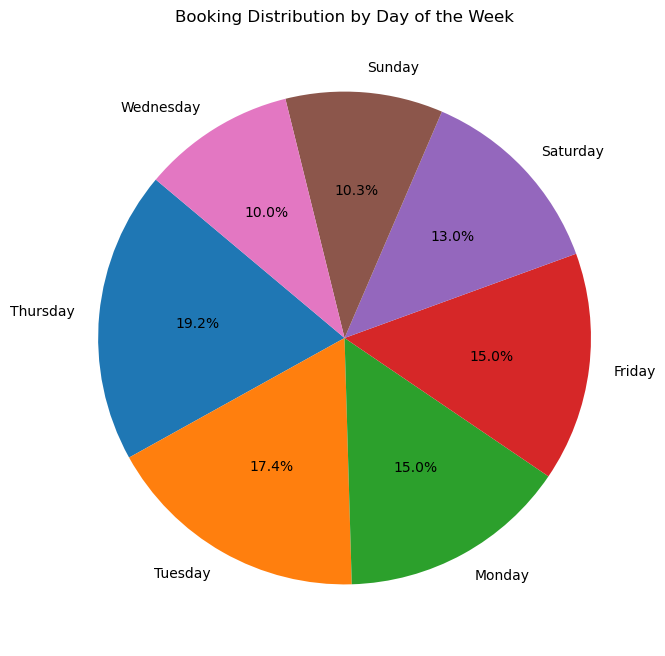

In [6]:
"""6: Days of the Week with Highest Number of Bookings"""
# Add day of week to bookings
bookings['day_of_week'] = bookings['booking_time'].dt.day_name()

# Count bookings per day of week
bookings_per_day = bookings['day_of_week'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
bookings_per_day.plot.pie(autopct='%1.1f%%', startangle=140)
plt.title("Booking Distribution by Day of the Week")
plt.ylabel('')
plt.show()


In [7]:
"""7: Total Number of Bookings and Gross Booking Value by Service"""
# Group by service_name and calculate totals
service_summary = bookings.groupby('service_name').agg({
    'booking_id': 'count',
    'INR_Amount': 'sum'
}).rename(columns={'booking_id': 'total_bookings', 'INR_Amount': 'total_gross_booking_value'})

print(service_summary)


              total_bookings  total_gross_booking_value
service_name                                           
GOIBIBO                  186                 5897637.97
MMT                       48                  665669.08
YATRA                    105                 3378702.13


In [8]:
"""8: Most Booked Route for Customers with More Than 1 Booking"""
# Filter customers with more than one booking
customers_with_multiple_bookings = bookings['customer_id'].value_counts()
customers_with_multiple_bookings = customers_with_multiple_bookings[customers_with_multiple_bookings > 1].index

# Filter bookings for these customers
filtered_bookings = bookings[bookings['customer_id'].isin(customers_with_multiple_bookings)]

# Find most booked route
most_booked_route = filtered_bookings.groupby(['from_city', 'to_city']).size().idxmax()

print(f"Most booked route for customers with more than one booking: {most_booked_route}")


Most booked route for customers with more than one booking: ('Gurgaon', 'Roissy-en-France')


In [9]:
"""9: Top 3 Departure Cities with Most Advanced Bookings"""
# Filter cities with at least 5 departures
departure_counts = bookings['from_city'].value_counts()
valid_cities = departure_counts[departure_counts >= 5].index

# Filter bookings for valid cities
valid_bookings = bookings[bookings['from_city'].isin(valid_cities)]

# Find top 3 cities with most advanced bookings
top_departure_cities = valid_bookings.groupby('from_city')['days_to_departure'].mean().nlargest(3)

print("Top 3 departure cities with most advanced bookings:")
print(top_departure_cities)


Top 3 departure cities with most advanced bookings:
from_city
Bālāpur       46.166667
Devanhalli    29.583333
Chennai       26.187500
Name: days_to_departure, dtype: float64


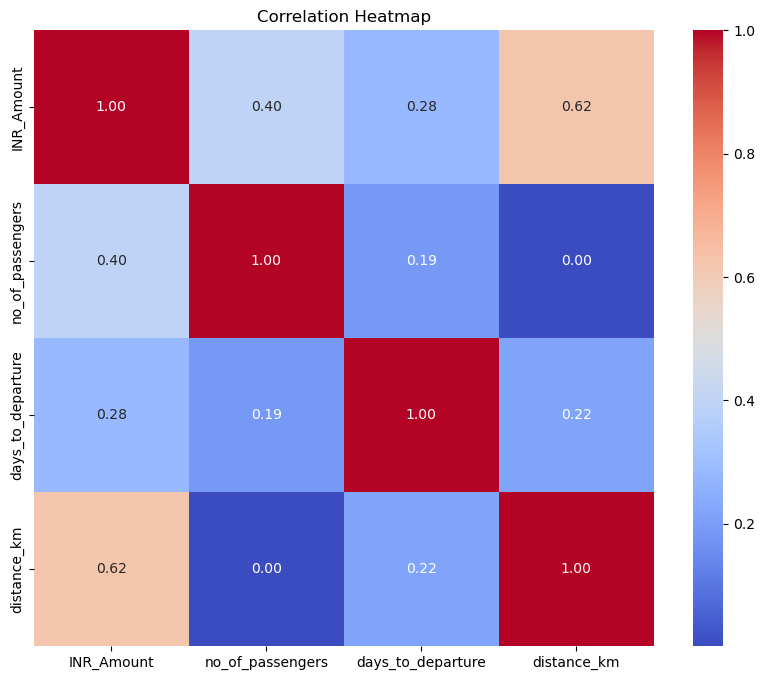

Pair of numerical columns with the maximum correlation: ('INR_Amount', 'distance_km')


In [10]:
"""10: Plot Heatmap of Correlations"""
# Select only numeric columns for correlation analysis
numeric_columns = bookings.select_dtypes(include=[np.number])

# Calculate correlations of numeric columns
correlation_matrix = numeric_columns.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

# Find the pair of numerical columns with the maximum correlation
max_corr_pair = correlation_matrix.abs().unstack().sort_values(ascending=False)
max_corr_pair = max_corr_pair[max_corr_pair < 1].idxmax()
print(f"Pair of numerical columns with the maximum correlation: {max_corr_pair}")


In [11]:
"""11. For each service, which is the most used 
device type for making bookings on the platform?"""
most_used_device = bookings.groupby('service_name')['device_type_used'].agg(lambda x: x.value_counts().idxmax())

print("Most used device type for each service:")
print(most_used_device)


Most used device type for each service:
service_name
GOIBIBO        IOS
MMT        Desktop
YATRA      Desktop
Name: device_type_used, dtype: object


C:\Users\Sujal Dev\AppData\Local\Temp\ipykernel_9660\1923702694.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  bookings['quarter'] = bookings['booking_time'].dt.to_period('Q')


<Figure size 1200x800 with 0 Axes>

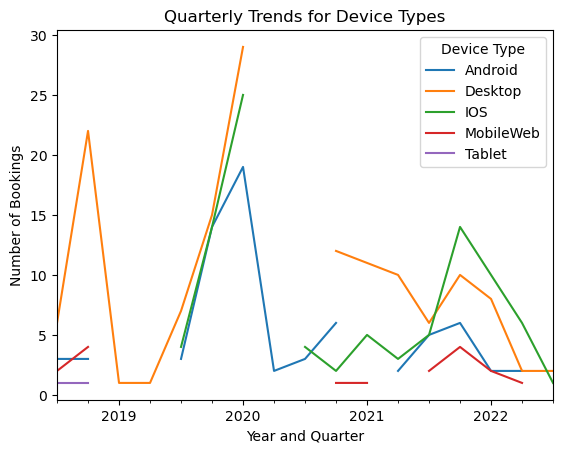

In [12]:
"""12. Plot the trends at a quarterly frequency for the number
of bookings by each of the device types"""

# Convert booking time to datetime
bookings['booking_time'] = pd.to_datetime(bookings['booking_time'])

# Extract year and quarter
bookings['quarter'] = bookings['booking_time'].dt.to_period('Q')

# Group by quarter and device type
quarterly_device_trends = bookings.groupby(['quarter', 'device_type_used'])['booking_id'].count().unstack()

# Plot quarterly trends
plt.figure(figsize=(12, 8))
quarterly_device_trends.plot(kind='line')
plt.title("Quarterly Trends for Device Types")
plt.ylabel("Number of Bookings")
plt.xlabel("Year and Quarter")
plt.legend(title='Device Type')
plt.show()


In [13]:
"""13a: Calculate Average oBSR by Month"""
# Add month column
sessions['month'] = sessions['session_starting_time'].dt.month

# Filter sessions with bookings
sessions_with_bookings = sessions[sessions['booking_id'].notnull()]

# Calculate oBSR by month
bookings_per_month = sessions_with_bookings.groupby('month').size()
total_sessions_per_month = sessions.groupby('month').size()
obsr_by_month = bookings_per_month / total_sessions_per_month
print("Average oBSR by Month:")
print(obsr_by_month)


Average oBSR by Month:
month
1.0     0.200000
2.0     0.222222
3.0     0.211268
4.0     0.200000
5.0     0.217391
6.0     0.285714
7.0     0.111111
8.0     0.416667
9.0     0.386364
10.0    0.260870
11.0    0.267606
12.0    0.230159
dtype: float64


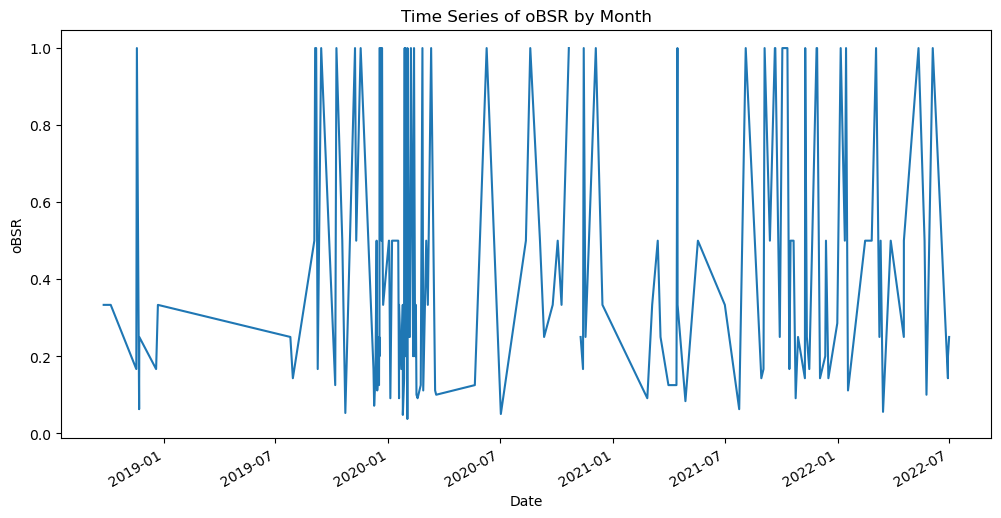

In [14]:
"""13b: Plot Time Series of oBSR by Month"""
# Calculate oBSR over time by month
obsr_by_month_over_time = sessions_with_bookings.groupby(['session_starting_time']).size() / sessions.groupby(['session_starting_time']).size()

# Plot time series of oBSR by month
plt.figure(figsize=(12, 6))
obsr_by_month_over_time.plot()
plt.title("Time Series of oBSR by Month")
plt.ylabel("oBSR")
plt.xlabel("Date")
plt.show()


In [15]:
"""13c. Calculate obsr by day of the week"""
# Add day of week to sessions
sessions['day_of_week'] = sessions['session_starting_time'].dt.day_name()

# Filter sessions with bookings
sessions_with_bookings = sessions[sessions['booking_id'].notnull()]

# Ensure the day_of_week column is present
print(sessions.head())

# Calculate oBSR by day of week
bookings_per_day = sessions_with_bookings.groupby('day_of_week').size()
total_sessions_per_day = sessions.groupby('day_of_week').size()
obsr_by_day = bookings_per_day / total_sessions_per_day

print("Average oBSR by Day of Week:")
print(obsr_by_day)


    session_id   search_id               search_time  \
0  session_322  search_784  2020-01-21T21:35:38.910Z   
1  session_322  search_776  2020-01-21T21:37:37.697Z   
2  session_322  search_623  2020-01-21T21:36:11.392Z   
3  session_322  search_270  2020-01-21T21:16:07.685Z   
4  session_322  search_905  2020-01-21T21:34:55.673Z   

      session_starting_time booking_id  month day_of_week  
0 2020-01-21 21:10:12+00:00        NaN    1.0     Tuesday  
1 2020-01-21 21:10:12+00:00        NaN    1.0     Tuesday  
2 2020-01-21 21:10:12+00:00        NaN    1.0     Tuesday  
3 2020-01-21 21:10:12+00:00        NaN    1.0     Tuesday  
4 2020-01-21 21:10:12+00:00        NaN    1.0     Tuesday  
Average oBSR by Day of Week:
day_of_week
Friday       0.235772
Monday       0.252252
Saturday     0.226087
Sunday       0.206349
Thursday     0.298969
Tuesday      0.259615
Wednesday    0.150794
dtype: float64


<Figure size 1200x600 with 0 Axes>

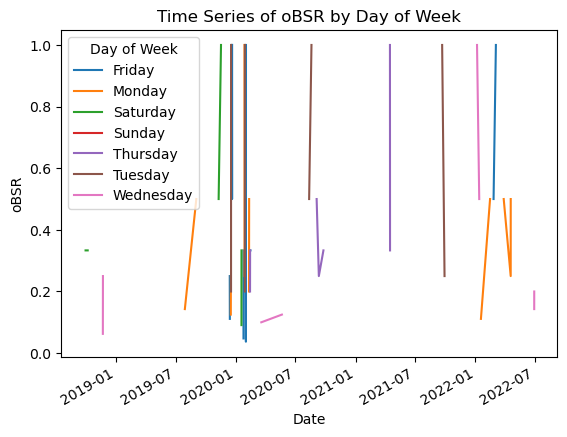

In [16]:
"""13d. plot obsr by the day of the week"""
# Calculate oBSR over time by day of week
obsr_by_day_over_time = sessions_with_bookings.groupby(['session_starting_time', 'day_of_week']).size() / sessions.groupby(['session_starting_time', 'day_of_week']).size()

# Reset index for plotting
obsr_by_day_over_time = obsr_by_day_over_time.reset_index(name='oBSR')
obsr_by_day_over_time_pivot = obsr_by_day_over_time.pivot(index='session_starting_time', columns='day_of_week', values='oBSR')

# Plot time series of oBSR by day of week
plt.figure(figsize=(12, 6))
obsr_by_day_over_time_pivot.plot()
plt.title("Time Series of oBSR by Day of Week")
plt.ylabel("oBSR")
plt.xlabel("Date")
plt.legend(title="Day of Week")
plt.show()


C:\Users\Sujal Dev\AppData\Local\Temp\ipykernel_9660\3815821107.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  bookings['quarter'] = bookings['booking_time'].dt.to_period('Q')


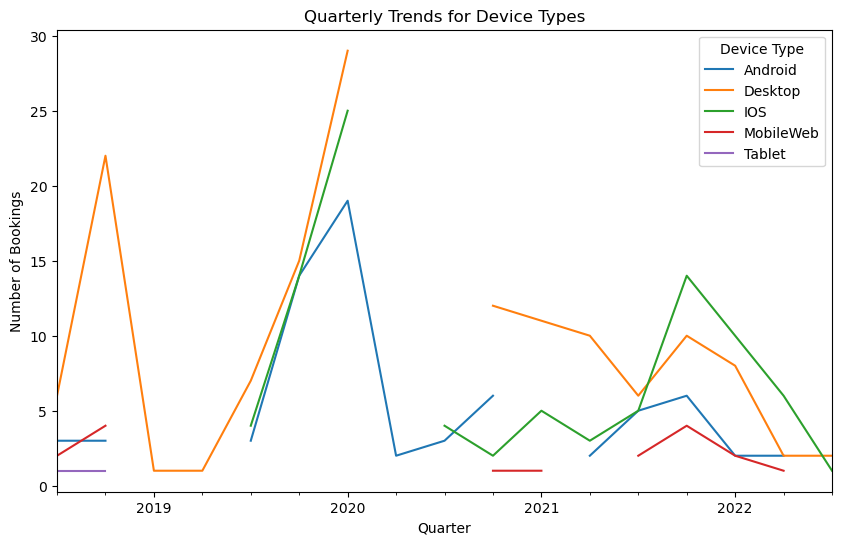

In [17]:
"""14.Plot Trends at Quarterly Frequency for Device Types"""
# Add 'quarter' column
bookings['quarter'] = bookings['booking_time'].dt.to_period('Q')

# Group by 'quarter' and 'device_type_used' and count bookings
quarterly_device_trends = bookings.groupby(['quarter', 'device_type_used'])['booking_id'].count().unstack()

# Plot trends
quarterly_device_trends.plot(kind='line', figsize=(10, 6))
plt.title("Quarterly Trends for Device Types")
plt.ylabel("Number of Bookings")
plt.xlabel("Quarter")
plt.legend(title="Device Type")
plt.show()
